In [656]:
import pandas as pd
from ast import literal_eval
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Classification of evaluations
The NLTK library and the sentiment analysis tool called VADER (Valence Aware Dictionary and sEntiment Reasoner) are used to analyze the sentiment or the overall emotional tone of a given text. In this case, we are leveraging sentiment analysis as a way to estimate the certainty or relevance of the text to a research question.

The sentiment analysis provided by VADER works by assigning a sentiment score to each word in the text and then aggregating those scores to provide an overall sentiment score. The scores are based on a pre-trained model that has been trained on a large corpus of texts. In other words, VADER uses a combination of qualitative and quantitative methods to identify and extract textual features related to sentiment and then calculates the sentiment scores based on these features.

Due to our data structure, we only evaluate the first sentence of each evaluation.

The sentiment scores provided by VADER include four values: positive, negative, neutral, and compound. The compound score represents the overall sentiment of the text, ranging from -1 (most negative) to +1 (most positive). By multiplying the compound score by 100 and converting it to an integer, we obtain a certainty score between 0 and 100.

In [657]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/philippeprince/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Maintaining the distinction between negative and positive sentiments

In [679]:
def calculate_certainty_score_D(text):
    sentiment_scores = sid.polarity_scores(text)
    certainty_score = int((sentiment_scores['compound'] + 1) * 50)
    return certainty_score


### Not distinguish between "positive" and "negative" sentiment. 
We are interested in the strength of the sentiment (i.e., how strongly the text suggests that the article is either relevant or not relevant), which is what the absolute value of the sentiment score can provide.

In [680]:
def calculate_certainty_score_ND(text):
    sentiment_scores = sid.polarity_scores(text)
    certainty_score = max(0, int(sentiment_scores['compound'] * 100))
    return certainty_score

### Use

In [661]:
df = pd.read_csv('eval_sentiment_GS.csv')
df['feedback_abstract'] = df['feedback_abstract'].apply(literal_eval)

In [681]:
def calculate_average_score(row, score_function):
    try:
        scores = [score_function(e) for e in row]
        average_score = sum(scores) / len(scores) if scores else 0
    except Exception as e:
        print(f"Error calculating score: {e}")
        average_score = 0
    return average_score

df['average_score_D'] = df['feedback_abstract'].apply(calculate_average_score, score_function=calculate_certainty_score_D)
ranking_D = df['average_score_D'].tolist()

df['average_score_ND'] = df['feedback_abstract'].apply(calculate_average_score, score_function=calculate_certainty_score_ND)
ranking_ND = df['average_score_ND'].tolist()

## Define whether the whole range of sentiments should be kept

- ranking_D: The ranking of articles when you use your function that maintains the distinction between negative and positive sentiment scores. Meaning, negative scores will not be set to zero and will be kept as they are.
- ranking_ND: The ranking of articles when you use your function that does not maintain the distinction between negative and positive sentiment scores. Meaning, all negative scores will be set to zero.

We will use these two rankings to compute Kendall's Tau. In this context, a high value of Tau (close to 1) would indicate that the two rankings are similar, suggesting that maintaining or not maintaining the distinction between negative and positive sentiments does not substantially change the ranking of the articles. On the other hand, a low value of Tau (close to -1) would suggest that the two rankings are dissimilar, indicating that this distinction does indeed have a substantial effect on the ranking.

The p_value is used to test the hypothesis that the rankings are uncorrelated. If p_value is small (typically, less than 0.05), you can reject the hypothesis and conclude that the rankings are indeed correlated.

The reason we use Kendall's Tau is that it is suitable for cases where there are many tied rankings (that is, many articles with the same score). Given that we are using a simple sentiment score to rank the articles, it's possible that many articles will end up with the same score, resulting in tied rankings.

Kendall's Tau does not tell which ranking is "better". It only measures how similar two rankings are. A high value of Tau would indicate that maintaining the distinction between negative and positive sentiments does not substantially change the ranking of the articles. On the other hand, a low value of Tau would suggest that this distinction does have a substantial effect on the ranking.

In [682]:
from scipy.stats import kendalltau

tau, p_value = kendalltau(ranking_D, ranking_ND)

print(f"Kendall's Tau: {tau}")

Kendall's Tau: 0.983843985905254


A Kendall's Tau value of 0.983843985905254 is very close to 1, which indicates a very high correlation between the two rankings we've tested - the one maintaining the distinction between negative and positive sentiments and the other not maintaining this distinction.

This result suggests that whether we preserve the distinction between negative and positive sentiment scores or set all negative scores to zero, it does not substantially change the ranking of the articles. In other words, the order in which the articles are ranked according to their relevance is nearly the same in both cases.

# Determining stopping point

Pour comprendre comment la moyenne des certainty_score évolue en fonction du nombre de points de données, nous créons une liste de moyennes cumulatives. Ensuite, nous traçons cette liste pour visualiser la stabilité de la moyenne sur la première ligne du dataset.

Dans ce code, une figure est générée pour la première ligne (line_df == 0) qui montre comment la moyenne cumulative des certainty_score évolue avec l'ajout de chaque nouveau point de données. Le graphique montre à quel point le nombre de données la moyenne commence à se stabiliser.

In [683]:
import matplotlib.pyplot as plt


for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        for i, e in enumerate(line):
            score = calculate_certainty_score_ND(e)
            scores.append(score)
            average_score = sum(scores) / len(scores) if scores else 0
            cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
        df.loc[line_df, 'average_score_ND'] = average_score

        # plot the cumulative averages for line 0
        if line_df == 0:
            plt.figure(figsize=(10, 6))
            plt.plot(cumulative_averages)
            plt.xlabel('Number of data points')
            plt.ylabel('Cumulative average of certainty score')
            plt.title('Cumulative average of certainty score vs Number of data points for line 0')
            plt.show()

    except:
        pass

Nous modifions le code pour inclure toutes les lignes non vides. Nous attribuons une couleur différente à chaque ligne pour les distinguer sur le graphique. Dans ce code, chaque ligne de df['feedback_abstract'] est tracée sur le même graphique avec une couleur différente. Les lignes vides sont ignorées. Le générateur de couleurs colors est utilisé pour obtenir une couleur différente pour chaque ligne.

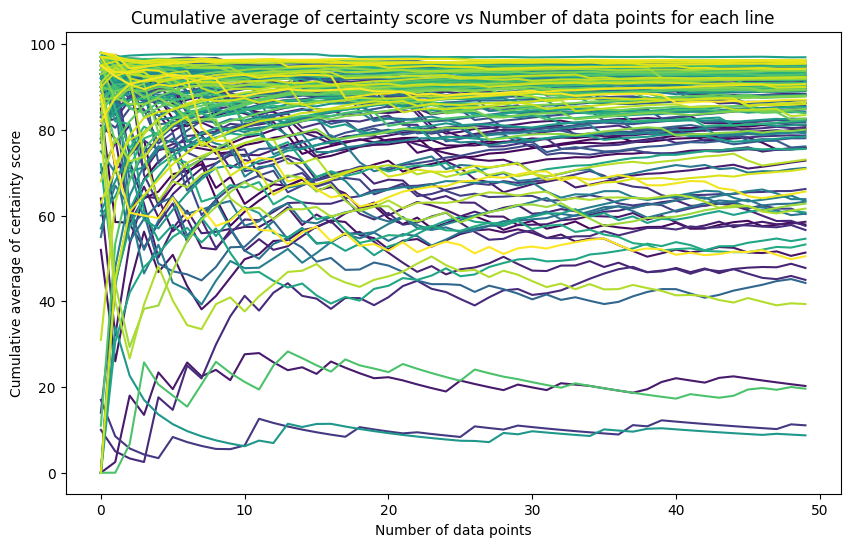

In [671]:
import matplotlib.pyplot as plt
import numpy as np

# Utiliser un générateur de couleurs pour différencier chaque ligne
colors = plt.cm.viridis(np.linspace(0, 1, len(df['feedback_abstract'])))

plt.figure(figsize=(10, 6))

for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        if line:  # vérifier si la ligne n'est pas vide
            for i, e in enumerate(line):
                score = calculate_certainty_score_ND(e)
                scores.append(score)
                average_score = sum(scores) / len(scores) if scores else 0
                cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
            df.loc[index, 'average_score_ND'] = average_score

            plt.plot(cumulative_averages, color=colors[index])

    except:
        pass

plt.xlabel('Number of data points')
plt.ylabel('Cumulative average of certainty score')
plt.title('Cumulative average of certainty score vs Number of data points for each line')
plt.show()


Nous déterminons s'il y a une tendance globale en calculant une moyenne sur toutes les lignes à chaque point de données et ensuite affichons cette moyenne. Nous obtenons une ligne de tendance globale qui montre comment la moyenne change à mesure qu'on ajoute plus de points de données.

Cette méthode suppose que chaque ligne a le même nombre de points de données.

Dans ce code, une moyenne globale est calculée à chaque point de données en additionnant les moyennes de chaque ligne à ce point et en divisant par le nombre total de lignes. Cette moyenne globale est ensuite tracée en rouge sur le graphique.

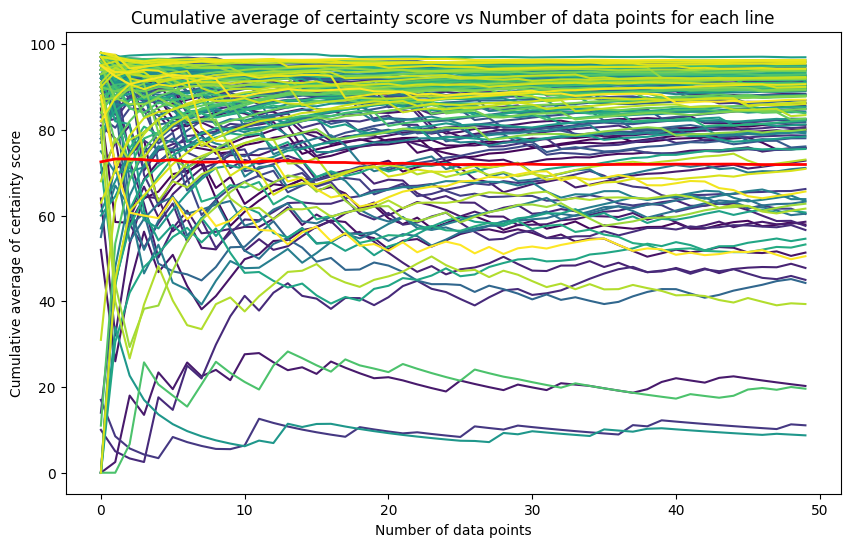

In [672]:
import matplotlib.pyplot as plt
import numpy as np

# Utiliser un générateur de couleurs pour différencier chaque ligne
colors = plt.cm.viridis(np.linspace(0, 1, len(df['feedback_abstract'])))

plt.figure(figsize=(10, 6))

global_averages = []  # liste pour stocker les moyennes globales

for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        if line:  # vérifier si la ligne n'est pas vide
            for i, e in enumerate(line):
                score = calculate_certainty_score_ND(e)
                scores.append(score)
                average_score = sum(scores) / len(scores) if scores else 0
                cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
            df.loc[index, 'average_score_ND'] = average_score

            plt.plot(cumulative_averages, color=colors[index])

            # Ajoute les scores cumulatifs à la liste globale
            if len(global_averages) < len(cumulative_averages):
                global_averages.extend([0] * (len(cumulative_averages) - len(global_averages)))

            for i in range(len(cumulative_averages)):
                global_averages[i] += cumulative_averages[i]

    except:
        pass

# Calcule la moyenne globale
global_averages = [x / len(df['feedback_abstract']) for x in global_averages]

# Tracer la moyenne globale
plt.plot(global_averages, color='red', linewidth=2)

plt.xlabel('Number of data points')
plt.ylabel('Cumulative average of certainty score')
plt.title('Cumulative average of certainty score vs Number of data points for each line')
plt.show()


Nous modifions le code pour n'afficher que la moyenne globale.

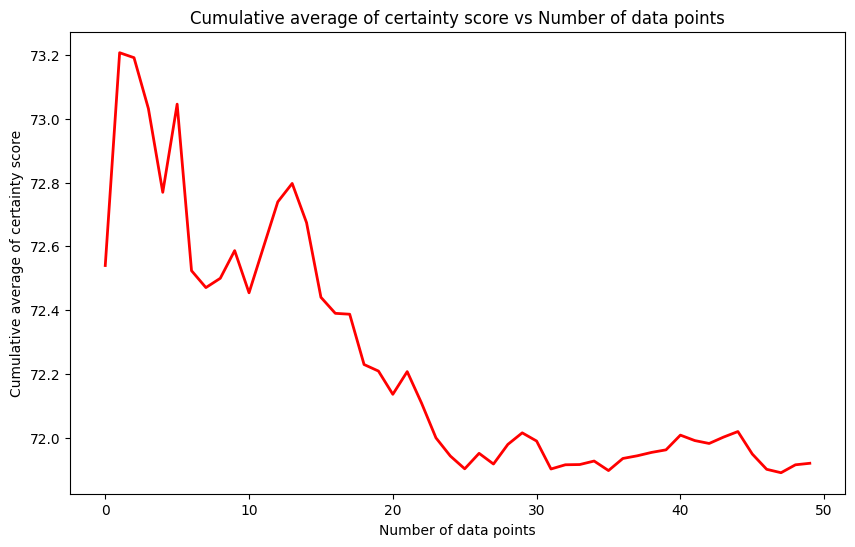

In [673]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

global_averages = []  # liste pour stocker les moyennes globales

for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        if line:  # vérifier si la ligne n'est pas vide
            for i, e in enumerate(line):
                score = calculate_certainty_score_ND(e)
                scores.append(score)
                average_score = sum(scores) / len(scores) if scores else 0
                cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
            df.loc[index, 'average_score_ND'] = average_score

            # Ajoute les scores cumulatifs à la liste globale
            if len(global_averages) < len(cumulative_averages):
                global_averages.extend([0] * (len(cumulative_averages) - len(global_averages)))

            for i in range(len(cumulative_averages)):
                global_averages[i] += cumulative_averages[i]

    except:
        pass

# Calcule la moyenne globale
global_averages = [x / len(df['feedback_abstract']) for x in global_averages]

# Tracer la moyenne globale
plt.plot(global_averages, color='red', linewidth=2)

plt.xlabel('Number of data points')
plt.ylabel('Cumulative average of certainty score')
plt.title('Cumulative average of certainty score vs Number of data points')
plt.show()


Pour déterminer mathématiquement où la moyenne commence à se stabiliser, nous calculons la dérivée (le taux de changement) de la moyenne globale. Lorsque la dérivée devient suffisamment petite (c'est-à-dire que le taux de changement est faible), on peut considérer que la moyenne commence à se stabiliser.

Dans ce code, la dérivée de la moyenne globale est calculée avec la fonction np.diff, qui calcule la différence entre des éléments consécutifs. Ensuite, on trouve l'indice où la dérivée est inférieure à au seuil de 0.01. Cet indice est le point où la moyenne commence à se stabiliser.

Ensuite, le graphique est tracé avec une ligne verticale bleue pour indiquer le point de stabilisation.

The average starts to stabilize around the 16th data point.


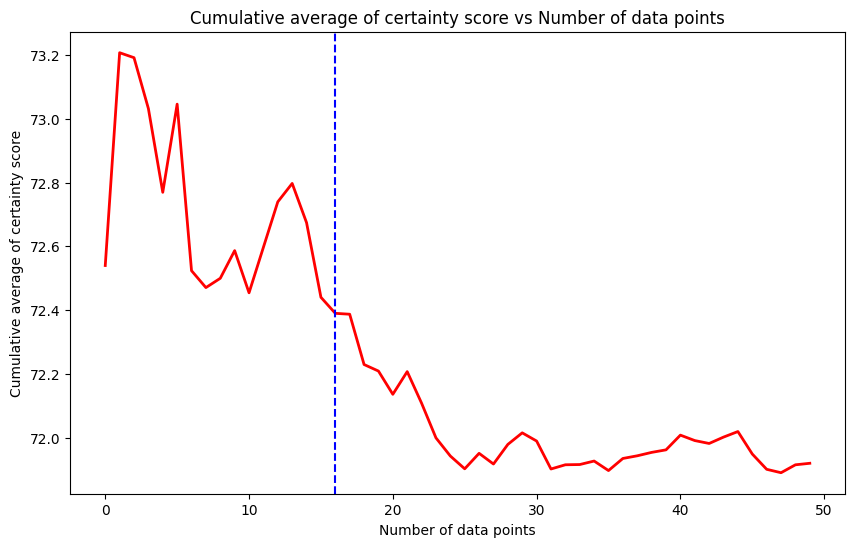

In [674]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

global_averages = []  # liste pour stocker les moyennes globales

for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        if line:  # vérifier si la ligne n'est pas vide
            for i, e in enumerate(line):
                score = calculate_certainty_score_ND(e)
                scores.append(score)
                average_score = sum(scores) / len(scores) if scores else 0
                cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
            df.loc[index, 'average_score_ND'] = average_score

            # Ajoute les scores cumulatifs à la liste globale
            if len(global_averages) < len(cumulative_averages):
                global_averages.extend([0] * (len(cumulative_averages) - len(global_averages)))

            for i in range(len(cumulative_averages)):
                global_averages[i] += cumulative_averages[i]

    except:
        pass

# Calcule la moyenne globale
global_averages = [x / len(df['feedback_abstract']) for x in global_averages]

# Calculer la dérivée
derivatives = np.diff(global_averages)

# Trouver l'indice où la dérivée est inférieure à un certain seuil
stabilization_index = next((i for i, x in enumerate(derivatives) if abs(x) < 0.01), None)

print(f"The average starts to stabilize around the {stabilization_index}th data point.")

# Tracer la moyenne globale et le point de stabilisation
plt.plot(global_averages, color='red', linewidth=2)
if stabilization_index is not None:
    plt.axvline(x=stabilization_index, color='blue', linestyle='--')

plt.xlabel('Number of data points')
plt.ylabel('Cumulative average of certainty score')
plt.title('Cumulative average of certainty score vs Number of data points')
plt.show()


Le seuil de 0.01 dans l'exemple précédent est un choix arbitraire, qui signifie que nous considérons que la moyenne se stabilise lorsque le taux de changement (la dérivée) est inférieur à 0.01. Pour choisir une valeur de seuil plus adaptée à aux données, nous effectuons un test de changement de point de CUSUM pour déterminer statistiquement si et quand un changement s'est produit dans la moyenne.

Le test de CUSUM (Cumulative Sum) est une méthode pour détecter un changement dans la moyenne d'une série de mesures. Pour appliquer le test de CUSUM à notre problème, nous utilisons la bibliothèque `ruptures` en Python qui est spécialisée dans la détection de ruptures.

Dans ce code, le test de CUSUM est effectué à l'aide de la bibliothèque ruptures. Le modèle "l2" est utilisé, ce qui signifie que la somme des carrés des résidus est minimisée. Le résultat de la méthode predict est une liste d'indices où un changement est détecté. Le graphique montre les points de rupture détectés.

Le paramètre `pen` dans la méthode predict est un paramètre de pénalité pour le nombre de ruptures. Plus la pénalité est élevée, moins il y aura de ruptures détectées.

<Figure size 1000x600 with 0 Axes>

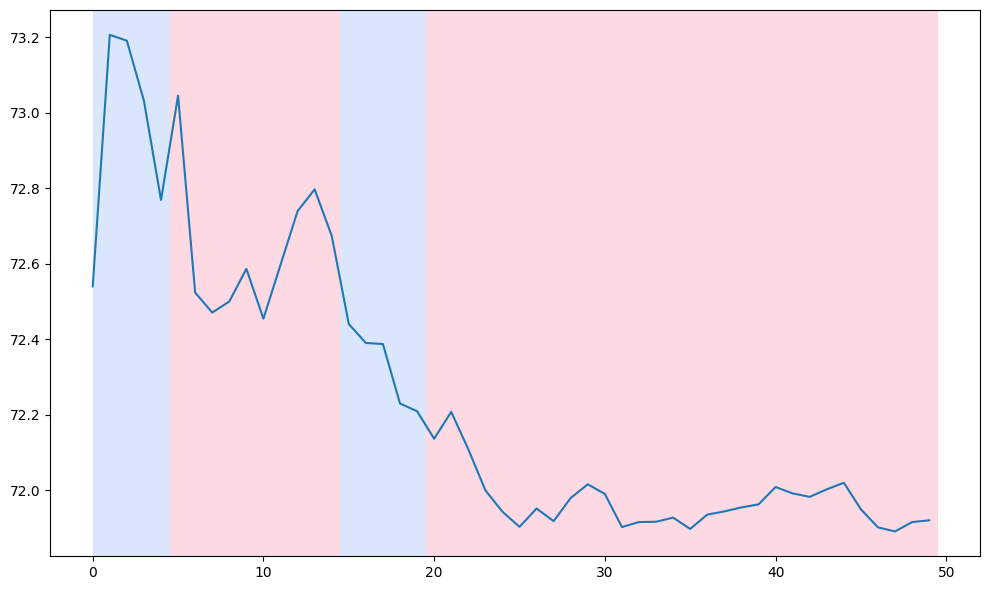

In [675]:
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

plt.figure(figsize=(10, 6))

global_averages = []  # liste pour stocker les moyennes globales

for index, line in enumerate(df['feedback_abstract']):
    scores = []
    cumulative_averages = []  # liste pour stocker les moyennes cumulatives
    try:
        if line:  # vérifier si la ligne n'est pas vide
            for i, e in enumerate(line):
                score = calculate_certainty_score_ND(e)
                scores.append(score)
                average_score = sum(scores) / len(scores) if scores else 0
                cumulative_averages.append(average_score)  # ajoute la moyenne cumulative actuelle à la liste
            df.loc[index, 'average_score'] = average_score

            # Ajoute les scores cumulatifs à la liste globale
            if len(global_averages) < len(cumulative_averages):
                global_averages.extend([0] * (len(cumulative_averages) - len(global_averages)))

            for i in range(len(cumulative_averages)):
                global_averages[i] += cumulative_averages[i]

    except:
        pass

# Calcule la moyenne globale
global_averages = [x / len(df['feedback_abstract']) for x in global_averages]

# Appliquer le test de CUSUM
model = "l2"  # modèle de coût
algo = rpt.Pelt(model=model).fit(np.array(global_averages))
result = algo.predict(pen=0.1)

# Tracer le graphique
rpt.display(np.array(global_averages), result, figsize=(10, 6))
plt.show()


Dans le graphique généré par la bibliothèque ruptures, chaque changement de couleur indique une "rupture" détectée dans les données, c'est-à-dire un point où la moyenne change significativement. Ces changements de couleur peuvent aider à visualiser les différentes "phases" des données.

Le point où la moyenne commence à se stabiliser serait idéalement la dernière rupture détectée, où la moyenne ne change plus de manière significative après cette rupture. Nous extrayons cet indice de la liste des résultats retournée par la méthode predict.

Dans ce code, result[-2] renvoie l'avant dernier élément de la liste result, qui est l'indice de la dernière rupture détectée. Si aucune rupture n'est détectée, result sera une liste vide et stabilization_index sera None.

Il est important de noter que le test de CUSUM et d'autres méthodes de détection de ruptures sont des outils statistiques qui peuvent aider à identifier les changements dans les données, mais ils ne fournissent pas de certitude absolue. Les résultats peuvent varier en fonction des paramètres choisis et de la nature spécifique des données. Il est toujours important de combiner ces outils avec une compréhension approfondie de vos données et du contexte dans lequel elles sont utilisées.

In [676]:
# Extraire l'indice de l'avant dernière rupture
stabilization_index = result[-2] if result else None

print(f"The average starts to stabilize around the {stabilization_index}th data point.")


The average starts to stabilize around the 20th data point.
